# Проект 13. Прогнозирование оттока клиентов телеком-компании

## Содержание
* [1. Описание задачи](#first)
* [2. Анализ и подготовка данных](#second)
* [3. Подготовка признаков](#third)
* [4. Обучение и тестирование моделей](#fourth)
* [5. Выводы](#fifth)

## 1. Описание задачи <a class="anchor" id="first"></a>

Оператор связи хочет научиться прогнозировать отток клиентов. На основе данных о клиентах необходимо построить модель для прогнозирования планирует ли пользователь отказаться от услуг или нет.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

## 2. Анализ и подготовка данных <a class="anchor" id="second"></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost as cb

In [2]:
# загрузка данных 
try:
    contract_df=pd.read_csv('D:\Datasets\contract.csv')
    personal_df=pd.read_csv('D:\Datasets\personal.csv')
    internet_df=pd.read_csv('D:\Datasets\internet.csv')
    phone_df=pd.read_csv('D:\Datasets\phone.csv')
except:
    contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
    internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
    personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
    phone_df_df = pd.read_csv('/datasets/final_provider/phone.csv')

### 2.1 Анализ данных о договорах (contracts.csv)

In [3]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Данные выглядят нормально. Пропусков в данных нет.

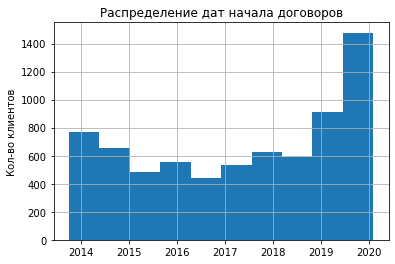

In [5]:
# приведём дату начала контракта к правильному формату и посмотрим на распределение данных
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format='%Y-%m-%d', errors='coerce')
contract_df['BeginDate'].hist()
plt.title('Распределение дат начала договоров')
plt.ylabel('Кол-во клиентов')
plt.show()

Есть контракты с 2014 года и по 2020. Посмотрим когда уходили клиенты.

In [6]:
# завершения контрактов
contract_df['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Котракты завершались всего в 4 даты, 1го числа каждого месяца. Либо что-то внезапно заставило заказчиков отказываться от услуг, именно начиная с сентября 2019, либо что-то с данными не так.<br/>
Данные актуальны на 01 февраля 2020 года. Хорошим признаком для дальнейшего обучения было бы знать сколько длился контракт тех, кто от него отказались. Для тех клиентов, которые всё ещё действующие, длительность контракта будем считать до сегодняшней даты(01.02.2020). Сохраним эти данные в столбце `contract_period`.

Сначала, чтобы было проще, создадим отдельный столбец `is_customer`, в котором будет указано, является ли пользователь ещё клиентом или уже нет. Этот столбец будем использовать как целевой признак в дальнейшем.

In [7]:
contract_df['is_customer'] = np.where(contract_df['EndDate']!='No', 0, 1)

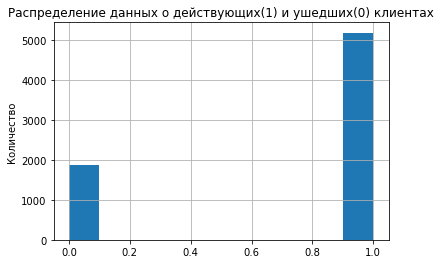

In [8]:
contract_df['is_customer'].hist()
plt.title('Распределение данных о действующих(1) и ушедших(0) клиентах')
plt.ylabel('Количество')
plt.show()

In [9]:
# заполним действующие контракты текущей датой
contract_df['EndDate'] = np.where(contract_df['EndDate']=='No', '2020-02-01 00:00:00', contract_df['EndDate'])

In [10]:
# переводим в формат дат
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], format='%Y-%m-%d', errors='coerce')

In [11]:
# считаем разницу даты конца действия контракта и начала в отдельный столбец
contract_df['contract_period']=(contract_df['EndDate']-contract_df['BeginDate']).dt.days

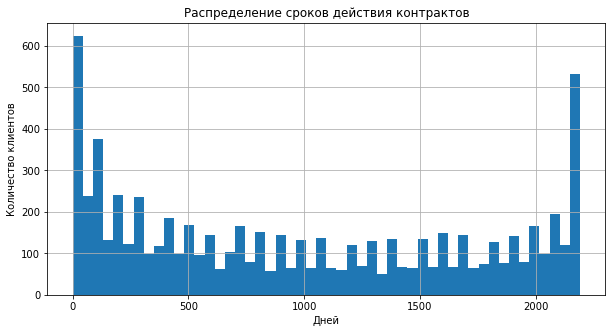

In [12]:
# смотрим сроки действия контрактов
contract_df['contract_period'].hist(bins=50, figsize=(10,5))
plt.title('Распределение сроков действия контрактов')
plt.ylabel('Количество клиентов')
plt.xlabel('Дней')
plt.show()

Достаточно много контрактов действовали совсем непродолжительное время, и так же много существуют давно. 

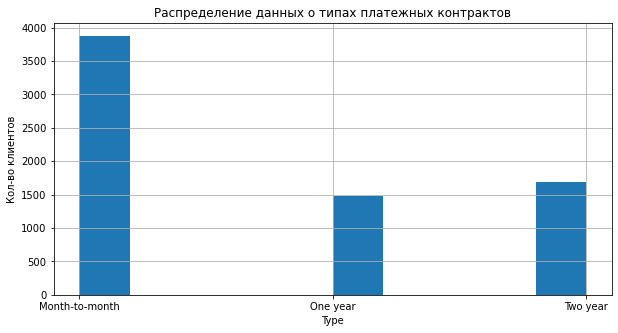

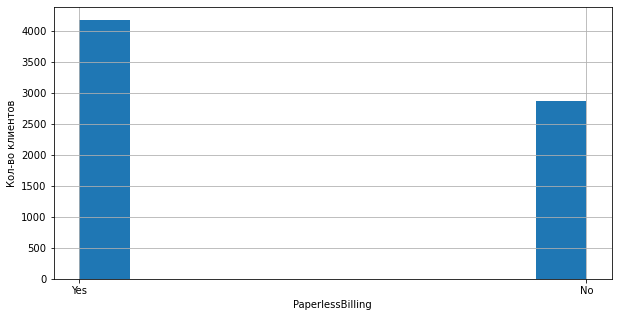

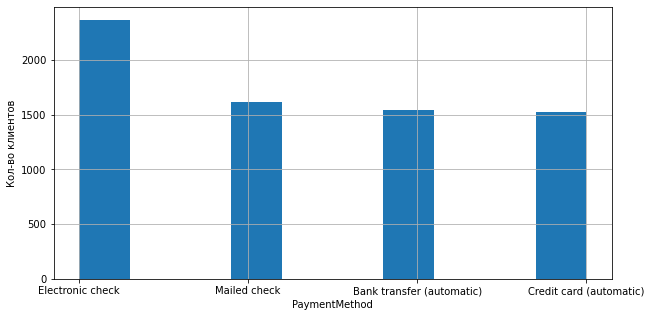

In [13]:
plt.title('Распределение данных о типах платежных контрактов')
for col in ['Type', 'PaperlessBilling', 'PaymentMethod']:
    contract_df[col].hist(figsize=(10,5))
    plt.ylabel('Кол-во клиентов')
    plt.xlabel(col)
    plt.show()

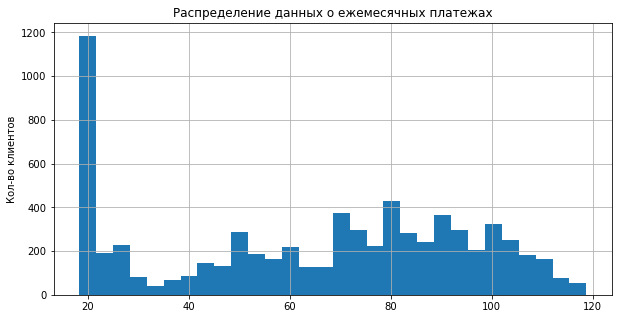

In [14]:
contract_df['MonthlyCharges'].hist(bins=30, figsize=(10,5))
plt.title('Распределение данных о ежемесячных платежах')
plt.ylabel('Кол-во клиентов')
plt.show()

Столбец `TotalCharges` имеет тип *object*, хотя там числовые данные. Некоторые строки содержат пробелы - это записи созданные на дату выгрузки(01.02.2020). Но мы не будем использовать этот столбец при обучении моделей, т.к. мы используем месячный платёж и длительность подписки - можем получить линейную зависимость признаков, что не очень хорошо.

#### Выводы:

1. Клиенты расторгают контракты последние 4 месяца.
2. Много контрактов совсем недавних(или быстро расторгнутых), но так же много и действующих много лет.
2. Большинство клиентов использует помесячные платежи. 
3. Средний ежемесячный платёж большинства клиентов около 20$. 

### 2.2 Анализ данных о клиентах (personal.csv)

In [15]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Посмотрим на распределения.

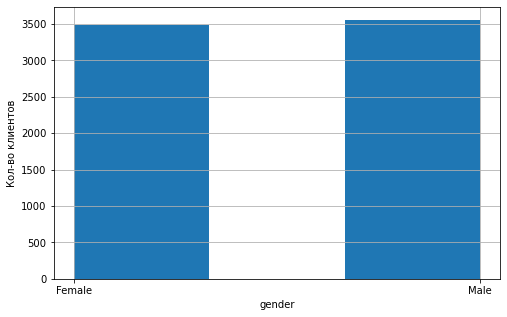

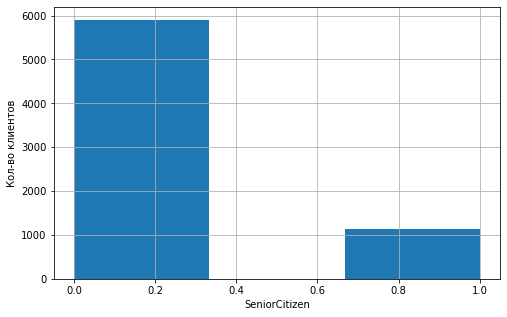

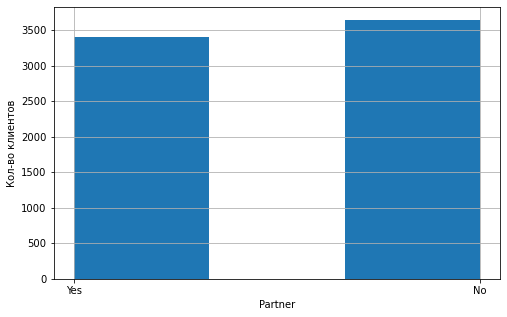

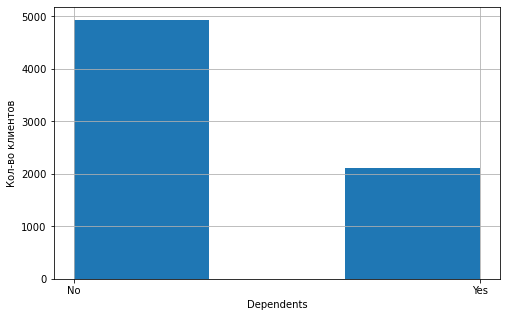

In [17]:
for col in ['gender','SeniorCitizen', 'Partner', 'Dependents']:
    personal_df[col].hist(bins=3, figsize=(8,5))
    plt.ylabel('Кол-во клиентов')
    plt.xlabel(col)
    plt.show()

Данные выглядят неплохо. Будем использовать их как признаки - персональная информация о клиенте похоже на важный признак для прогнозирования его поведения.

### 2.3 Анализ данных об услугах интернет (internet.csv)

In [18]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [19]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Посмотрим на распределение значений в столбцах.

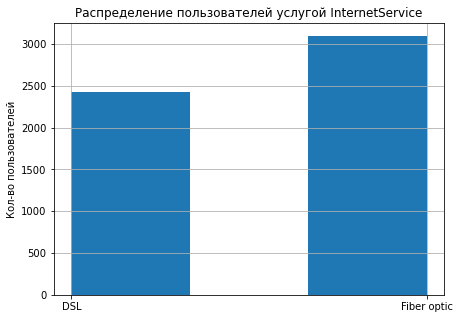

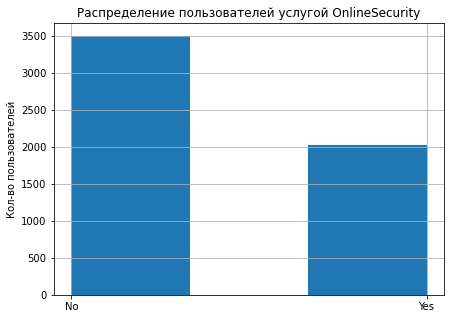

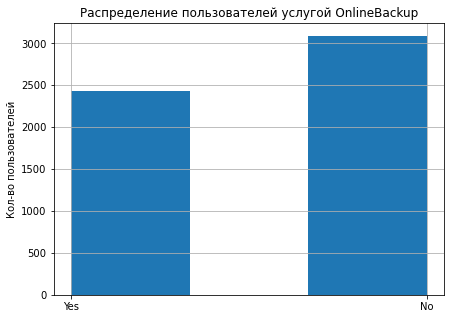

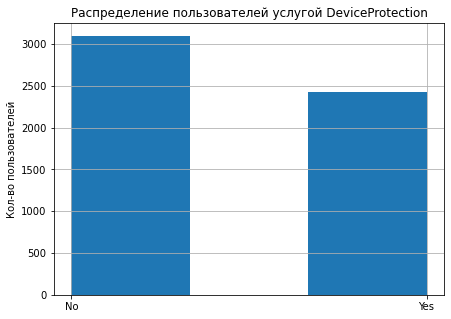

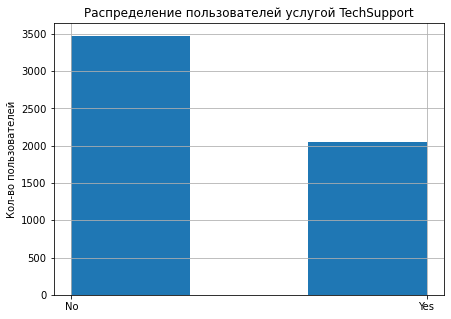

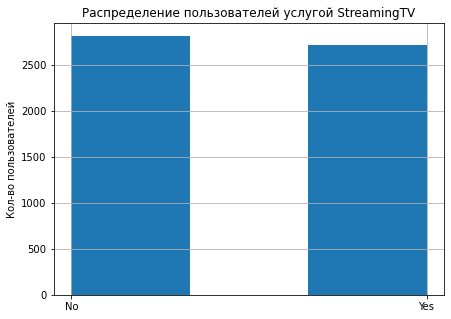

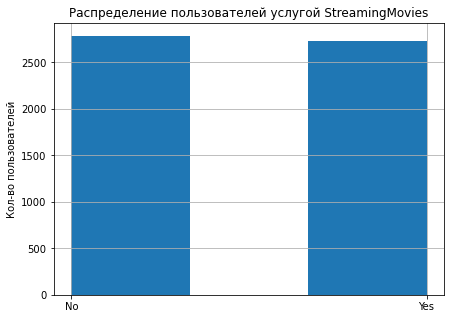

In [20]:
for col in ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    internet_df[col].hist(bins=3, figsize=(7,5))
    plt.title('Распределение пользователей услугой {}'.format(col))
    plt.ylabel('Кол-во пользователей')
    plt.show()

#### Выводы:

В целом, примерно равное отношение подписанных на каждую услугу пользоваталей и не подписанных. Можно только отметить, что техническая поддержка пользуется наименьшей популярностью.  

### 2.4 Анализ данных об услугах телефонии (phone.csv)

In [21]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [22]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


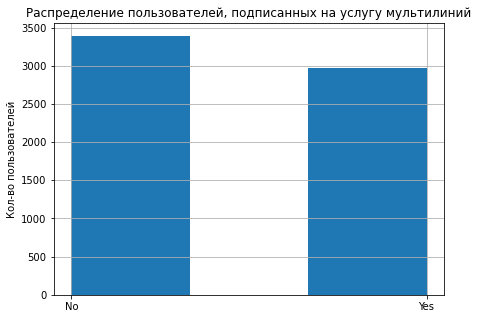

In [23]:
phone_df['MultipleLines'].hist(bins=3, figsize=(7,5))
plt.title('Распределение пользователей, подписанных на услугу мультилиний')
plt.ylabel('Кол-во пользователей')
plt.show()

Создадим отдельный столбец `phone_service` со значением 1. Этот столбец будет признаком, что клиент пользуется услугой телефонии в принципе.

In [24]:
phone_df['phone_service'] = 1

In [25]:
phone_df.head()

,customerID,MultipleLines,phone_service
0,5575-GNVDE,No,1
1,3668-QPYBK,No,1
2,9237-HQITU,No,1
3,9305-CDSKC,Yes,1
4,1452-KIOVK,Yes,1


ок, тут всё просто)

## 3. Подготовка признаков для обучения <a class="anchor" id="third"></a>

Соберём все данные в единый датафрейм `data` через ID клиентов.

In [26]:
# данные из контрактов
data=contract_df[['customerID','Type','PaperlessBilling','PaymentMethod','MonthlyCharges', 'is_customer','contract_period']]
data.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,is_customer,contract_period
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,1,31
1,5575-GNVDE,One year,No,Mailed check,56.95,1,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,0,61
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,0,61


In [27]:
# добавляем данные из других таблиц
data = pd.merge(data,personal_df, how='left', on='customerID')
data = pd.merge(data,internet_df, how='left', on='customerID')
data = pd.merge(data, phone_df, how='left', on='customerID')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   is_customer       7043 non-null   int32  
 6   contract_period   7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null   object 


Чтобы отделит пользоваталей интернета от тех, кто его не использует, заполним пропуски в колонке `InternetService` значениями *No service*.

In [29]:
data['InternetService'] = data['InternetService'].fillna('No service')

Также необходимо отделить тех, кто не пользуется услугами телефонии и тех, кто ими пользуется, но не использует доп. сервис мультилиний. Для этого мы и создавали столбец `phone_service` ранее. Теперь просто заполним его пропуски нулями. 

In [30]:
data['phone_service'] = data['phone_service'].fillna(0)

Пропуски в остальных столбцах заполним *No*. 

In [31]:
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']:
    data[col]=data[col].fillna('No')

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   is_customer       7043 non-null   int32  
 6   contract_period   7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null   object 


In [33]:
data.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,is_customer,contract_period,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,phone_service
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,1,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0.0
1,5575-GNVDE,One year,No,Mailed check,56.95,1,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1.0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,0,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1.0
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0.0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,0,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1.0


Хорошо.
Теперь необходимо подготовить признаки. Почти все они являются категориальными.
* Для признаков со значениями Yes-No, `gender` будем использовать бинарное кодирование.
* Для остальных признаков - One-hot-encoding

In [34]:
# бинарно кодируем столбцы с yes-no
for col in ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']:
    data[col] = np.where(data[col]=='No', 0, 1)

In [35]:
# столбец gender тоже бинарно кодируем, 0-мужчина, 1-женщина
data['gender']=np.where(data['gender']=='Male', 0, 1)

In [36]:
# кодируем OHE категориальные признаки
col=['Type', 'PaymentMethod','InternetService']
data=pd.get_dummies(data, columns=col)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               7043 non-null   object 
 1   PaperlessBilling                         7043 non-null   int32  
 2   MonthlyCharges                           7043 non-null   float64
 3   is_customer                              7043 non-null   int32  
 4   contract_period                          7043 non-null   int64  
 5   gender                                   7043 non-null   int32  
 6   SeniorCitizen                            7043 non-null   int64  
 7   Partner                                  7043 non-null   int32  
 8   Dependents                               7043 non-null   int32  
 9   OnlineSecurity                           7043 non-null   int32  
 10  OnlineBackup                             7043 no

Собираем обучающие и целевой признаки.

In [38]:
label=data['is_customer']
features=data.drop(['is_customer', 'customerID'], axis=1)

In [39]:
# разбиваем на тренировочную и тестовую выборки
features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2)

print('Features train:', features_train.shape)
print('Label train:', label_train.shape)
print('---')
print('Features test:', features_test.shape)
print('Label test:', label_test.shape)

Features train: (5634, 25)
Label train: (5634,)
---
Features test: (1409, 25)
Label test: (1409,)


In [40]:
# стандартизируем числовые признаки через StandartScaler
num_features=['MonthlyCharges', 'contract_period']
scaler=StandardScaler()
scaler.fit(features_train[num_features])

StandardScaler()

In [41]:
features_train[num_features]=scaler.transform(features_train[num_features])
features_test[num_features]=scaler.transform(features_test[num_features])

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
G:\Anaconda\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
G:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [42]:
features_train.head()

,PaperlessBilling,MonthlyCharges,contract_period,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No service
6049,0,-1.489191,0.600665,1,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1
4025,1,0.328231,-1.152962,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
6309,0,-1.304959,1.579963,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2846,1,-0.091685,-1.234682,1,0,1,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0
1177,0,0.474289,0.559135,1,0,0,0,1,0,1,...,0,0,1,0,0,0,1,1,0,0


Получилось достаточно много признаков. Посмотрим, какие из них важны для обучения модели.

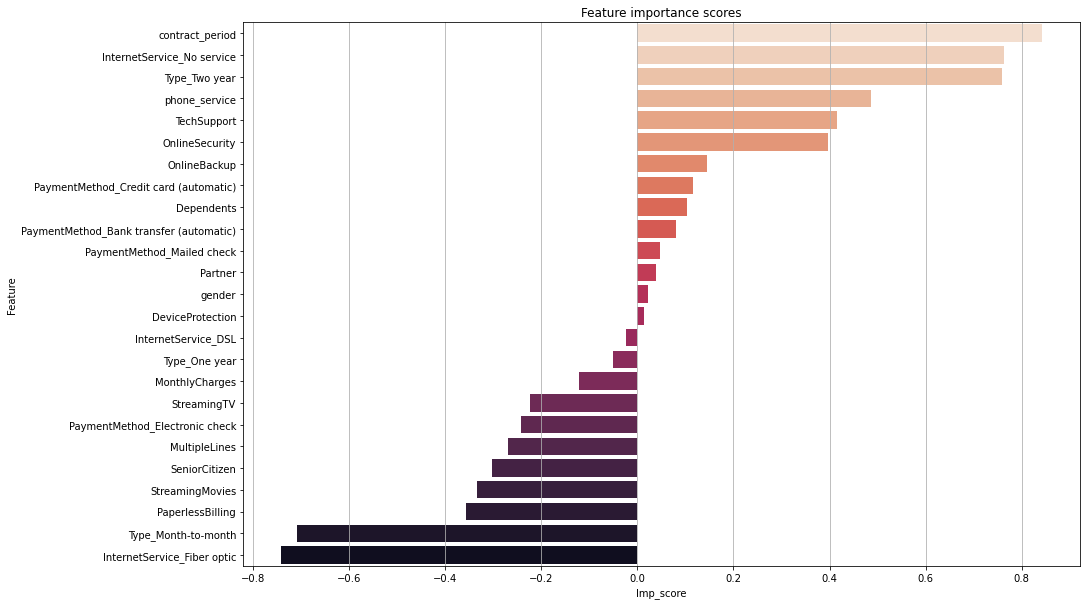

In [43]:
# посмотрим на примере лог.регрессии
model = LogisticRegression()
model.fit(features_train, label_train)

importance = model.coef_[0]

# собираем датафрейм с данными
feat_imp=pd.DataFrame()
feat_imp['Feature']=features_train.columns
feat_imp['Imp_score'] = importance

# строим график
plt.figure(figsize=(15,10))
plt.grid(axis='both', which='both')
plt.title('Feature importance scores')
sns.barplot(x='Imp_score', y='Feature', data=feat_imp.sort_values(by='Imp_score', ascending=False), palette='rocket_r')
plt.show()

Почти половина признаков не сильно коррелируют с целевым признаком. Не будем их использовать и удалим их из обучающей и тестовой выборок.

In [44]:
bad_features=['MultipleLines', 'PaymentMethod_Electronic check', 'PaperlessBilling', 'Type_Month-to-month', 'InternetService_Fiber optic', 'StreamingMovies', 'SeniorCitizen', 'StreamingTV', 'DeviceProtection', 'MonthlyCharges', 'Type_One year', 'gender', 'Partner']

In [45]:
features_train=features_train.drop(bad_features, axis=1)
features_test=features_test.drop(bad_features,axis=1)

print('Обучающая выборка: ', features_train.shape)
print('Тестовая выборка', features_test.shape)

Обучающая выборка:  (5634, 12)
Тестовая выборка (1409, 12)


Осталось всего 12 признаков! 
Теперь посмотрим на баланс классов.

<AxesSubplot:>

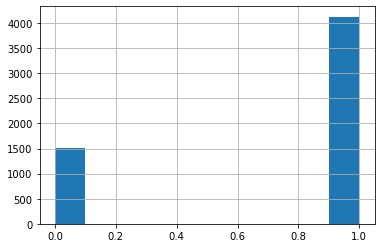

In [46]:
# смотрим на распределение целевого признака
label_train.hist()

Классы не сбалансированы. Т.к. у нас не очень много данных, сделаем upsampling нулевого класса.

In [47]:
def upsample(features_df, target_df, repeat):
    features_zeros = features_df[target_df == 0]
    features_ones = features_df[target_df == 1]
    target_zeros = target_df[target_df == 0]
    target_ones = target_df[target_df == 1]

    features_upsampled = pd.concat([features_ones] + [features_zeros] * repeat)
    target_upsampled = pd.concat([target_ones] + [target_zeros] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=11111)
    
    return features_upsampled, target_upsampled

<AxesSubplot:>

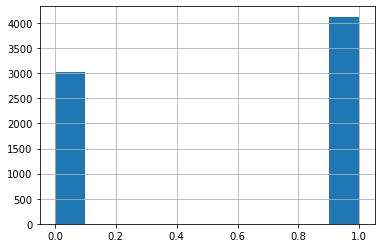

In [48]:
# создаем новый набор данных для обучения
features_upsamp, label_upsamp = upsample(features_train, label_train, 2)
label_upsamp.hist()

Небольшой дисбаланс присутствует, но не страшно. Константная модель (только 1) должна показать Accuracy около 58%. Учтём это.

Признаки готовы, переходим к обучению моделей!

## 4. Обучение и тестирование моделей <a class="anchor" id="fourth"></a>

In [49]:
# функция для тестирования и скоринга
def test_me(cur_model):    
    probabilities_test = cur_model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    fpr, tpr, thresholds = roc_curve(label_test, probabilities_one_test)
    
    # F1 score
    predictions = cur_model.predict(features_test)
    print('F1_Score=',f1_score(label_test, predictions))
    
    #график
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
            
    # AUC-ROC SCORE
    auc_roc = roc_auc_score(label_test, probabilities_one_test)
    print('ROC-AUC Score=', auc_roc)
    accur = accuracy_score(label_test, predictions)
    print('Accuracy=', accur)
    
    plt.show()  
    return [auc_roc, accur]

In [50]:
# таблица с результатами
result = pd.DataFrame(columns = ['ROC-AUC score', 'Accuracy'])

### 4.1 Logistic Regression

In [51]:
model_lr=LogisticRegression(max_iter=1000)
model_lr.fit(features_upsamp, label_upsamp)

LogisticRegression(max_iter=1000)

F1_Score= 0.8262195121951219
ROC-AUC Score= 0.8287253388594025
Accuracy= 0.7572746628814763


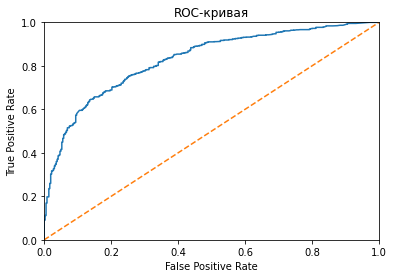

In [52]:
score_lr=test_me(model_lr)

In [53]:
result.loc['LogRegression']=score_lr
result

,ROC-AUC score,Accuracy
LogRegression,0.828725,0.757275


### 4.2. XGBoost

In [54]:
def XGB_cv_grid():
    xgb_m = xgb.XGBClassifier(random_state=112211)
    param_grid = {
            "n_estimators"      : [2000],
            "learning_rate"     : [0.01],
            "max_depth" : [2,4,10],
            "min_child_weight" : [2,4]
            }

    xgb_grid = GridSearchCV(xgb_m, param_grid, n_jobs=-1, cv=5, scoring='roc_auc')
    xgb_grid.fit(features_upsamp, label_upsamp)

    print('...Search completed...')
    return xgb_grid.best_params_

In [55]:
#xgb_params=XGB_cv_grid()
xgb_params = {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 2000}
xgb_params

{'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 2000}

In [56]:
model_xgb=XGBClassifier(**xgb_params)
model_xgb.fit(features_upsamp,label_upsamp)

[13:17:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


G:\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

F1_Score= 0.9054966248794599
ROC-AUC Score= 0.9074956122729482
Accuracy= 0.8608942512420156


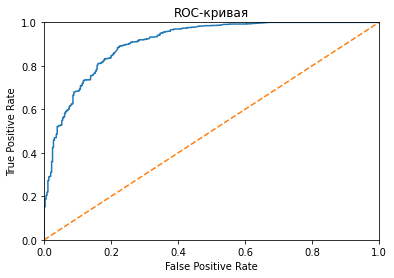

In [57]:
score_xgb = test_me(model_xgb)

In [58]:
result.loc['XGBoost'] = score_xgb
result

,ROC-AUC score,Accuracy
LogRegression,0.828725,0.757275
XGBoost,0.907496,0.860894


### 4.3 LightGBM

In [59]:
def LGB_cv_grid():
    lgb_m = lgb.LGBMClassifier(random_state=112211)
    param_grid = {
            "num_leaves"        : [500,1000],
            "learning_rate"     : [0.1, 0.01],
            "max_depth" : [-1, 2],
            "reg_lambda": [1,2],
            "min_child_weight" : [2,3,5]
            }

    lgb_grid = GridSearchCV(lgb_m, param_grid, n_jobs=-1, cv=5, scoring='roc_auc')
    lgb_grid.fit(features_upsamp, label_upsamp)

    print('...Search completed...')
    return lgb_grid.best_params_

In [60]:
#lgb_params=LGB_cv_grid()
lgb_params = {'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 2, 'num_leaves': 500, 'reg_lambda': 1}
lgb_params

{'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_weight': 2,
 'num_leaves': 500,
 'reg_lambda': 1}

In [61]:
model_lgb=lgb.LGBMClassifier(**lgb_params)
model_lgb.fit(features_upsamp, label_upsamp)

LGBMClassifier(min_child_weight=2, num_leaves=500, reg_lambda=1)

F1_Score= 0.9050814956855225
ROC-AUC Score= 0.9119203442515489
Accuracy= 0.8594748048261178


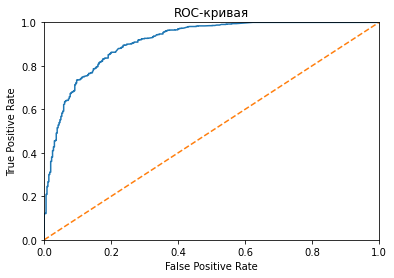

In [62]:
score_lgb=test_me(model_lgb)

In [63]:
result.loc['LightGBM']=score_lgb
result

,ROC-AUC score,Accuracy
LogRegression,0.828725,0.757275
XGBoost,0.907496,0.860894
LightGBM,0.911920,0.859475


### 4.4 Catboost Classifier

In [64]:
def CB_cv_grid():
    cb_m = cb.CatBoostClassifier(random_state=112211)
    param_grid = {
            "iterations"        : [5000,10000],
            "learning_rate"     : [0.1, 0.01],
            "l2_leaf_reg" : [2],
            "max_depth": [6],
            "max_leaves" : [31],
            'verbose' : [1000]
            }

    lgb_grid = GridSearchCV(cb_m, param_grid, n_jobs=-1, cv=5, scoring='roc_auc')
    lgb_grid.fit(features_upsamp, label_upsamp)

    print('...Search completed...')
    return lgb_grid.best_params_

In [65]:
#cb_params=CB_cv_grid()
cb_params = {'iterations': 10000, 'l2_leaf_reg': 2, 'learning_rate': 0.01, 'max_depth': 6, 'max_leaves': 31, 'verbose': 1000}
cb_params

{'iterations': 10000,
 'l2_leaf_reg': 2,
 'learning_rate': 0.01,
 'max_depth': 6,
 'max_leaves': 31,
 'verbose': 1000}

In [66]:
model_cb=cb.CatBoostClassifier(**cb_params)
model_cb.fit(features_upsamp, label_upsamp)

0:	learn: 0.6879051	total: 73ms	remaining: 12m 9s
1000:	learn: 0.3606382	total: 2.54s	remaining: 22.8s
2000:	learn: 0.2864464	total: 5.02s	remaining: 20.1s
3000:	learn: 0.2459697	total: 7.88s	remaining: 18.4s
4000:	learn: 0.2219175	total: 10.7s	remaining: 16s
5000:	learn: 0.2042339	total: 13.3s	remaining: 13.2s
6000:	learn: 0.1906580	total: 15.8s	remaining: 10.5s
7000:	learn: 0.1798677	total: 18.4s	remaining: 7.88s
8000:	learn: 0.1712523	total: 21s	remaining: 5.26s
9000:	learn: 0.1641970	total: 23.8s	remaining: 2.64s
9999:	learn: 0.1578751	total: 26.4s	remaining: 0us


F1_Score= 0.917590361445783
ROC-AUC Score= 0.9385744644858428
Accuracy= 0.8786373314407381


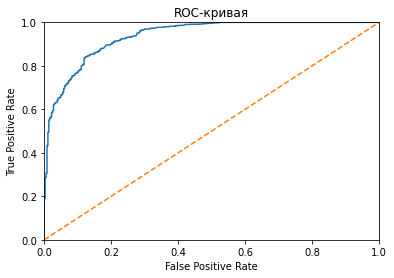

In [67]:
cb_score=test_me(model_cb)

In [68]:
result.loc['CatBoost'] = cb_score

### 4.5 Выводы

Проведено обучение и валидация различных моделей. Оптимальные гиперпараметры для разных моделей были подобраны с помощью кросс-валидации на обучающей выборке. <br/>
В качестве основной метрики качества использовалась ROC-AUC. В качестве дополнительной - Accuracy. <br/>
Были получены следующие результаты:

In [69]:
result

,ROC-AUC score,Accuracy
LogRegression,0.828725,0.757275
XGBoost,0.907496,0.860894
LightGBM,0.911920,0.859475
CatBoost,0.938574,0.878637


## 5. Выводы <a class="anchor" id="fifth"></a>

Целью работы было  построить модель для прогнозирования планирует ли пользователь отказаться от услуг или нет, на основе данных о клиентах Компании.

Входными данными была информация о котрактах пользователей, их персональные данные, а также перечне услуг и опций, которые они используют.<br/>
Данные были загружены, проанализированы и обработаны.<br/>

Среди сложностей, можно отметить большое количество категориальных признаков. Для уменьшения их количества была проведена оценка влияния на целевой признак.<br/>
Было установлено, что следующие параметры больше всего влияют на возможность ухода клиента:
* Срок действия контракта
* Заключение контракта на 2 года
* Использование доп. услуг(особенно тех. поддержка, онлайн-безопасность и бэкап)
* Автоматические платежи

По результатам анализа были определёны и подготовлены признаки для обучения моделей.<br/> 
Данные были разбиты на обучающую и тестовую выборки в соотношении 1:5. 

В ходе работы были обучены и проанализированы следующие модели: LogisticRegression, XGBoostClassifier, LightGBMClassifier, CatBoostClassifier. Для каждой модели были подобраны оптимальные гипер-параметры на обучающей выборке методом кросс-валидации. В качестве контролируемой метрики использовалась ROC-AUC score, в качестве дополнительной - Accuracy. <br/>

По результатам тестирования, лучшие значения метрик показала следующая модель:<br/>
**CatBoostClassifier** <br/>
**Параметры:** `{'iterations': 10000, 'l2_leaf_reg': 2, 'learning_rate': 0.01, 'max_depth': 6, 'max_leaves': 31, 'verbose': 1000}` <br/>
**Метрика ROC-AUC:** 0.938574 <br/>
**Метрика Accuracy:** 0.878637